### 1. Imports

In [1]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_tree
import numpy as np
from matplotlib.pylab import rcParams

### 2. Load Data

In [2]:
# Load the dataset
df = pd.read_csv('prepared_data.csv')

# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

# Display the first few rows
df.head()

,symbol,streak_len,direction,occurrence,performance,vol,ma5_pos,ma200_pos,ma5_neg,ma200_neg,next_day_actual,bin_name
date,,,,,,,,,,,,
2025-02-27,TSLA,6,-1,19,-1,1,0,1,1,0,1,6 -1 -1 -1 1 0 1 1 0
2025-02-26,TSLA,5,-1,53,-1,1,0,1,1,0,-1,5 -1 -1 -1 1 0 1 1 0
2025-02-25,MSFT,3,-1,620,-1,-1,0,0,-1,1,1,3 -1 -1 -1 -1 0 0 -1 1
2025-02-25,TSLA,4,-1,103,-1,-1,0,1,1,0,-1,4 -1 -1 -1 -1 0 1 1 0
2025-02-24,TSLA,3,-1,230,-1,-1,0,1,-1,0,-1,3 -1 -1 -1 -1 0 1 -1 0


### 3. Preprocessing

In [3]:
# Remove rows where 'next_day_actual' is 0 (no change)
df = df[df['next_day_actual'] != 0]

# Convert -1 to 0 in 'next_day_actual'
df['next_day_actual'] = df['next_day_actual'].replace(-1, 0)

# Ensure 'streak_len' is integer and drop unnecessary columns
df['streak_len'] = df['streak_len'].astype(int)
df.drop(columns=['symbol', 'bin_name', 'occurrence'], inplace=True)

# Display unique values in 'next_day_actual'
df['next_day_actual'].unique()

array([1, 0])

### 4. Exploratory Data Analysis (EDA)

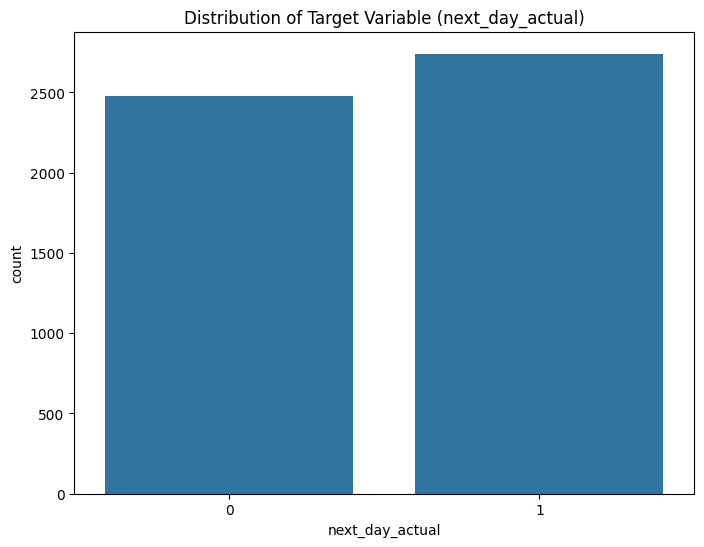

In [4]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='next_day_actual', data=df)
plt.title('Distribution of Target Variable (next_day_actual)')
plt.show()

**Correlation Heatmap:** visualizes the relationships between variables in the dataset. It uses colors to represent the strength and direction of correlations:
- **1**: Strong positive correlation (dark red).
- **-1**: Strong negative correlation (dark blue).
- **0**: No correlation (white).

This helps identify which features are strongly related and guides feature selection for modeling.

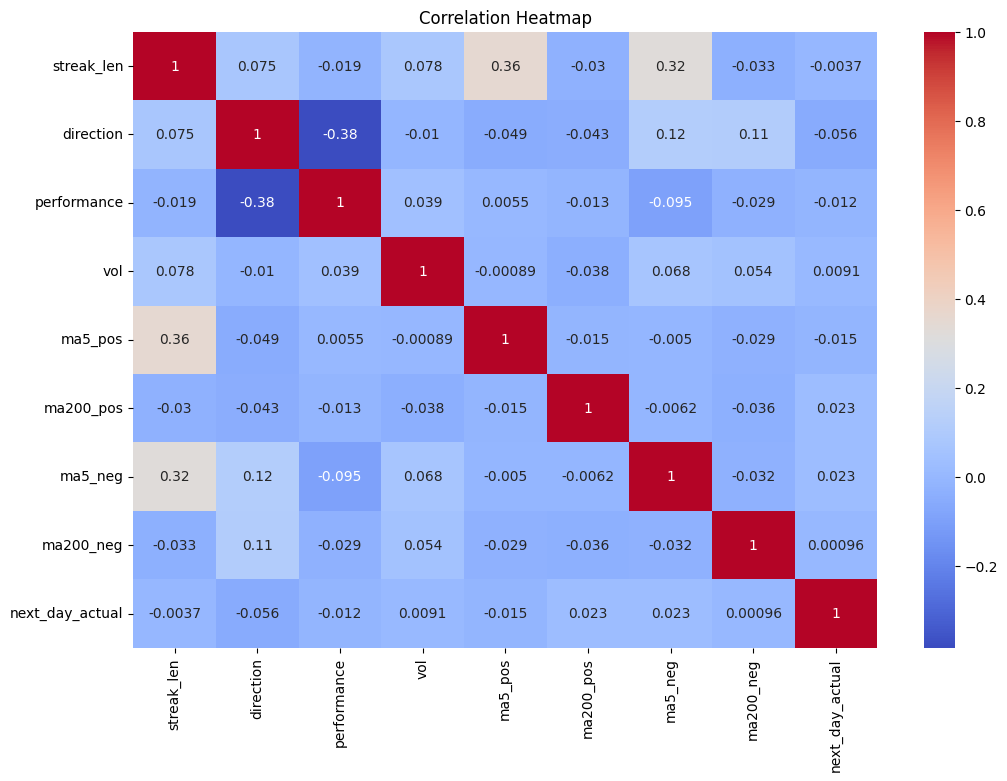

In [5]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 5. Train-Test Split

In [6]:
# Split data into features and target
x = df.iloc[:,:-1]
y = df['next_day_actual']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

### 6. One-Hot Encoding

In [7]:
cols = x.columns.to_list()
cols

['streak_len',
 'direction',
 'performance',
 'vol',
 'ma5_pos',
 'ma200_pos',
 'ma5_neg',
 'ma200_neg']

In [8]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[cols])
encoded_cols = list(encoder.get_feature_names_out(cols)) # it retrieves the names of the new encoded features created by the OneHotEncoder and stores them in the list encoded_cols.

In [9]:
x_train[encoded_cols] = encoder.transform(x_train[cols])
x_test[encoded_cols] = encoder.transform(x_test[cols])

In [10]:
x_train.columns

Index(['streak_len', 'direction', 'performance', 'vol', 'ma5_pos', 'ma200_pos',
       'ma5_neg', 'ma200_neg', 'streak_len_3', 'streak_len_4', 'streak_len_5',
       'streak_len_6', 'streak_len_7', 'streak_len_8', 'streak_len_9',
       'streak_len_10', 'streak_len_11', 'streak_len_12', 'streak_len_13',
       'direction_-1', 'direction_0', 'direction_1', 'performance_-1',
       'performance_0', 'performance_1', 'vol_-1', 'vol_0', 'vol_1',
       'ma5_pos_-1', 'ma5_pos_0', 'ma5_pos_1', 'ma200_pos_-1', 'ma200_pos_0',
       'ma200_pos_1', 'ma5_neg_-1', 'ma5_neg_0', 'ma5_neg_1', 'ma200_neg_-1',
       'ma200_neg_0', 'ma200_neg_1'],
      dtype='object')

In [11]:
# Remove original columns and keep only encoded columns
x_train = x_train[encoded_cols]
x_test = x_test[encoded_cols]

In [12]:
x_train.columns

Index(['streak_len_3', 'streak_len_4', 'streak_len_5', 'streak_len_6',
       'streak_len_7', 'streak_len_8', 'streak_len_9', 'streak_len_10',
       'streak_len_11', 'streak_len_12', 'streak_len_13', 'direction_-1',
       'direction_0', 'direction_1', 'performance_-1', 'performance_0',
       'performance_1', 'vol_-1', 'vol_0', 'vol_1', 'ma5_pos_-1', 'ma5_pos_0',
       'ma5_pos_1', 'ma200_pos_-1', 'ma200_pos_0', 'ma200_pos_1', 'ma5_neg_-1',
       'ma5_neg_0', 'ma5_neg_1', 'ma200_neg_-1', 'ma200_neg_0', 'ma200_neg_1'],
      dtype='object')

In [13]:
# Note: Boolean conversion (astype(bool)) was removed because it caused:
# 1. Mismatch in sample counts between parent/child nodes in decision trees.
# 2. Distortion of split thresholds (e.g., 0.5 checks became ambiguous).
# Rationale: One-hot encoded features (0.0/1.0 floats) work correctly without conversion.


# # Convert encoded columns and target column to boolean
# x_train = x_train.astype(bool)
# x_test = x_test.astype(bool)
# y_train = y_train.astype(bool)
# y_test = y_test.astype(bool)

### 7. Hyperparameter Tuning

In [14]:
# Hyperparameter and Model Management for XGBoost
def get_best_xgboost_params(X, y):
    """Get optimal parameters (run tuning only if no saved params exist)"""
    params_path = "xgboost_best_params.pkl"
    
    if os.path.exists(params_path):
        print("✅ Loading previously optimized XGBoost parameters...")
        return joblib.load(params_path)
    else:
        print("🚀 Performing initial XGBoost hyperparameter tuning...")
        param_grid = {
            'max_depth': [3, 4, 5],
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
        
        grid_search = GridSearchCV(
            estimator=XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
            param_grid=param_grid,
            scoring='accuracy',
            cv=3
        )
        grid_search.fit(X, y)
        
        best_params = grid_search.best_params_
        joblib.dump(best_params, params_path)
        print(f"✅ Saved optimal XGBoost parameters: {best_params}")
        return best_params

# Get parameters (tunes only on first run)
best_params = get_best_xgboost_params(x_train, y_train)

✅ Loading previously optimized XGBoost parameters...


### 8. Model Training

In [15]:
# Safe Train Function for XGBoost
def safe_train_xgboost(model_name, X_train, y_train, model_params):
    """Train or load XGBoost model with consistent parameters"""
    model_path = f"{model_name}.pkl"
    params_path = f"{model_name}_params.pkl"
    
    if os.path.exists(model_path):
        print(f"✅ {model_name} already trained! Loading...")
        model = joblib.load(model_path)
        
        # Verify parameters match
        saved_params = joblib.load(params_path)
        if saved_params != model_params:
            print("⚠️ Warning: Current parameters differ from saved model's parameters")
        
        return model
    else:
        print(f"🚀 Training {model_name} with optimized parameters...")
        model = XGBClassifier(
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss',
            **model_params
        )
        model.fit(X_train, y_train)
        
        # Save both model and parameters
        joblib.dump(model, model_path)
        joblib.dump(model_params, params_path)
        print(f"✅ {model_name} trained & saved with parameters")
        return model

In [16]:
# XGBoost Model Configuration and Training
model_params = {
    **best_params  # Always use the optimal parameters
}

# Train/load model
model = safe_train_xgboost("xg_boost_model", x_train, y_train, model_params)

✅ xg_boost_model already trained! Loading...


In [17]:
# Predictions
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

In [18]:
print(train_preds, test_preds)

[1 1 1 ... 0 1 0] [1 1 1 ... 1 1 0]


### 9. Model Evaluation (Confusion Matrix, ROC Curve)

**Confusion Matrix:**
A confusion matrix is a table used to evaluate the performance of a classification model. It shows:
- **True Positives (TP)**: Correctly predicted positive cases.
- **True Negatives (TN)**: Correctly predicted negative cases.
- **False Positives (FP)**: Negative cases incorrectly predicted as positive.
- **False Negatives (FN)**: Positive cases incorrectly predicted as negative.

It helps visualize how well the model is performing and identify where it makes mistakes.

**Confusion Matrix (2D Array):**
In a confusion matrix `m`:

- **`m[0, 0]`**: True Negatives (TN) – Correctly predicted negatives.
- **`m[0, 1]`**: False Positives (FP) – Incorrectly predicted positives (Type I Error).
- **`m[1, 0]`**: False Negatives (FN) – Incorrectly predicted negatives (Type II Error).
- **`m[1, 1]`**: True Positives (TP) – Correctly predicted positives.

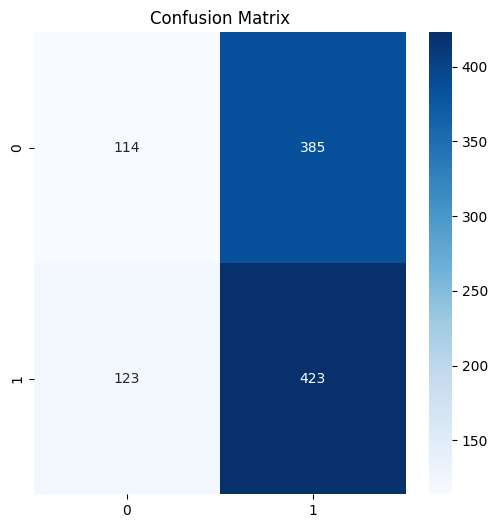

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

**ROC Curve (Receiver Operating Characteristic Curve):**
The ROC Curve visualizes the performance of a binary classification model by plotting:
- **True Positive Rate (TPR)** (y-axis): The proportion of actual positives correctly predicted.
- **False Positive Rate (FPR)** (x-axis): The proportion of actual negatives incorrectly predicted as positives.

- **AUC-ROC Score**: The area under the ROC curve, ranging from 0 to 1:
  - **1**: Perfect classifier.
  - **0.5**: Random classifier.
  - **< 0.5**: Worse than random.

The ROC Curve helps evaluate how well the model distinguishes between the two classes at different classification thresholds.

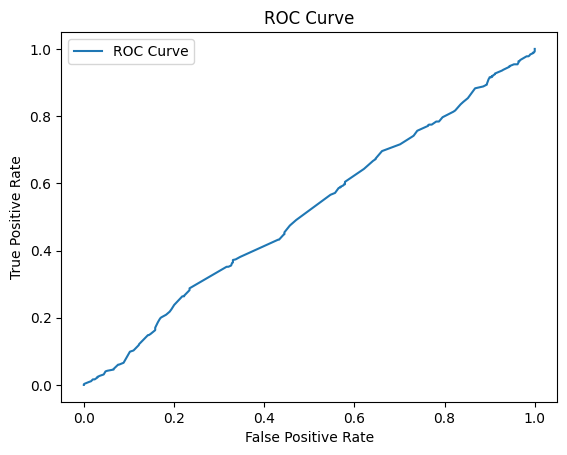

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [21]:
print("AUC-ROC Score:", roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

AUC-ROC Score: 0.5145162119110015


In [22]:
# Evaluation
print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("\nClassification Report (Training):\n", classification_report(y_train, train_preds))
print("\nClassification Report (Test):\n", classification_report(y_test, test_preds))

Training Accuracy: 0.5534003831417624
Test Accuracy: 0.5138755980861244

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.56      0.27      0.36      1980
           1       0.55      0.81      0.66      2196

    accuracy                           0.55      4176
   macro avg       0.56      0.54      0.51      4176
weighted avg       0.56      0.55      0.52      4176


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.48      0.23      0.31       499
           1       0.52      0.77      0.62       546

    accuracy                           0.51      1045
   macro avg       0.50      0.50      0.47      1045
weighted avg       0.50      0.51      0.47      1045



### 10. Visualization

In [23]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

importance_df

,Feature,Importance
27,ma5_neg_0,0.122505
17,vol_-1,0.069621
0,streak_len_3,0.062172
26,ma5_neg_-1,0.056102
16,performance_1,0.055971
31,ma200_neg_1,0.053861
22,ma5_pos_1,0.053537
30,ma200_neg_0,0.050852
25,ma200_pos_1,0.049425
14,performance_-1,0.048426


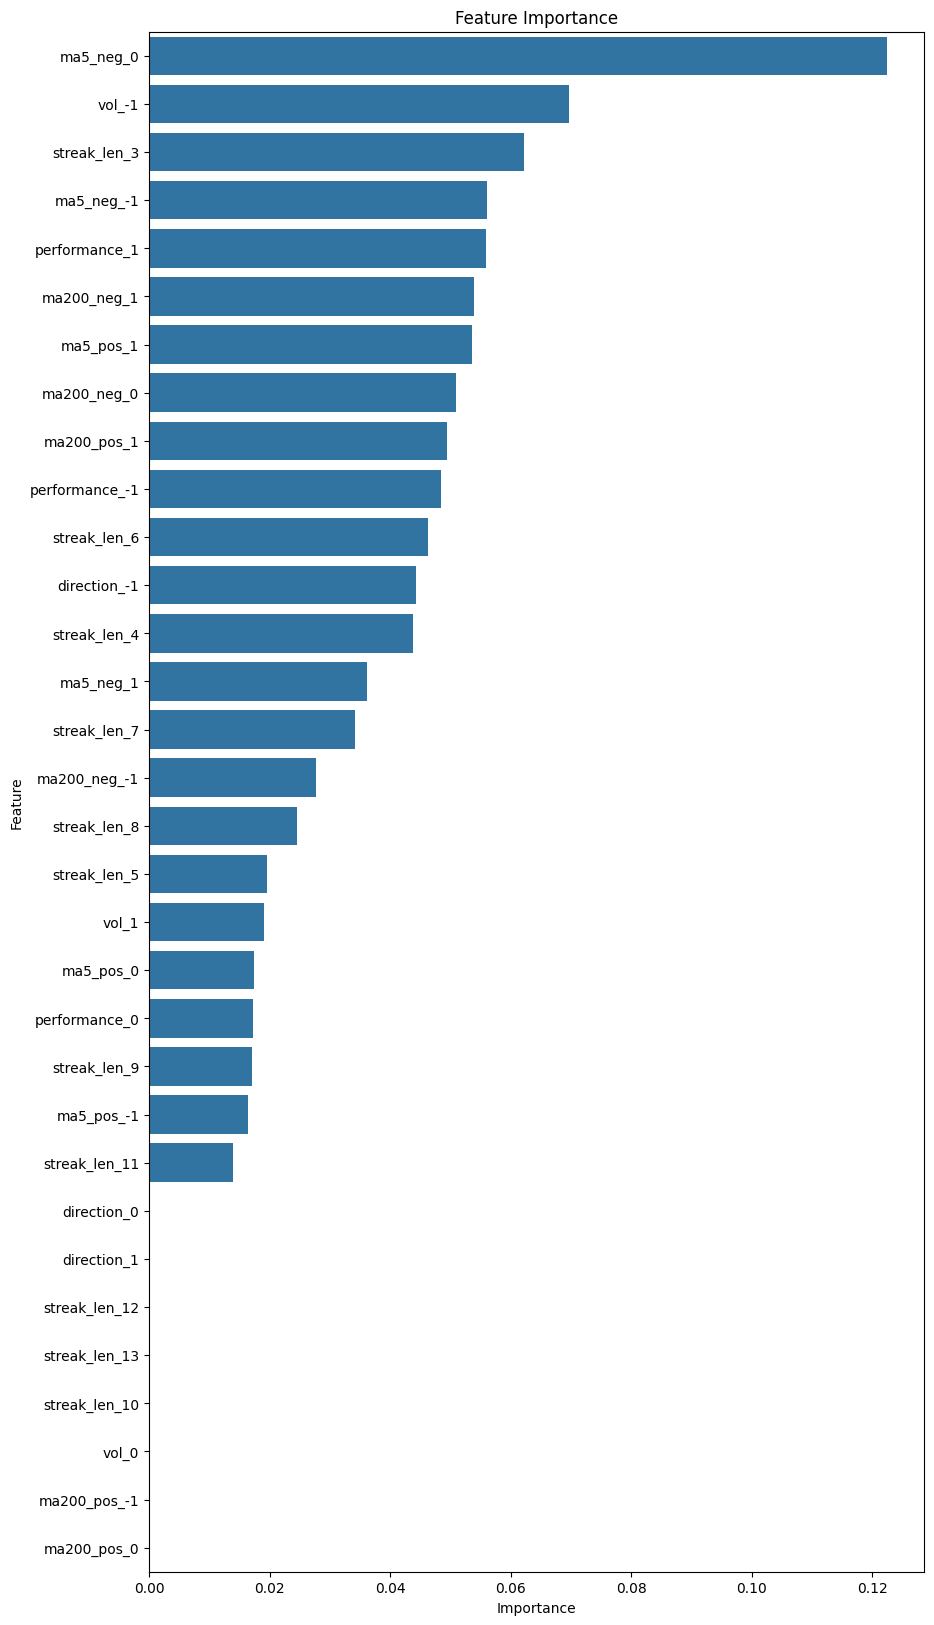

In [24]:
plt.figure(figsize=(10, 20))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.yticks(rotation=0)
plt.show()

In [25]:
# Visualization: Plot individual trees
rcParams['figure.figsize'] = 30, 30

<Axes: >

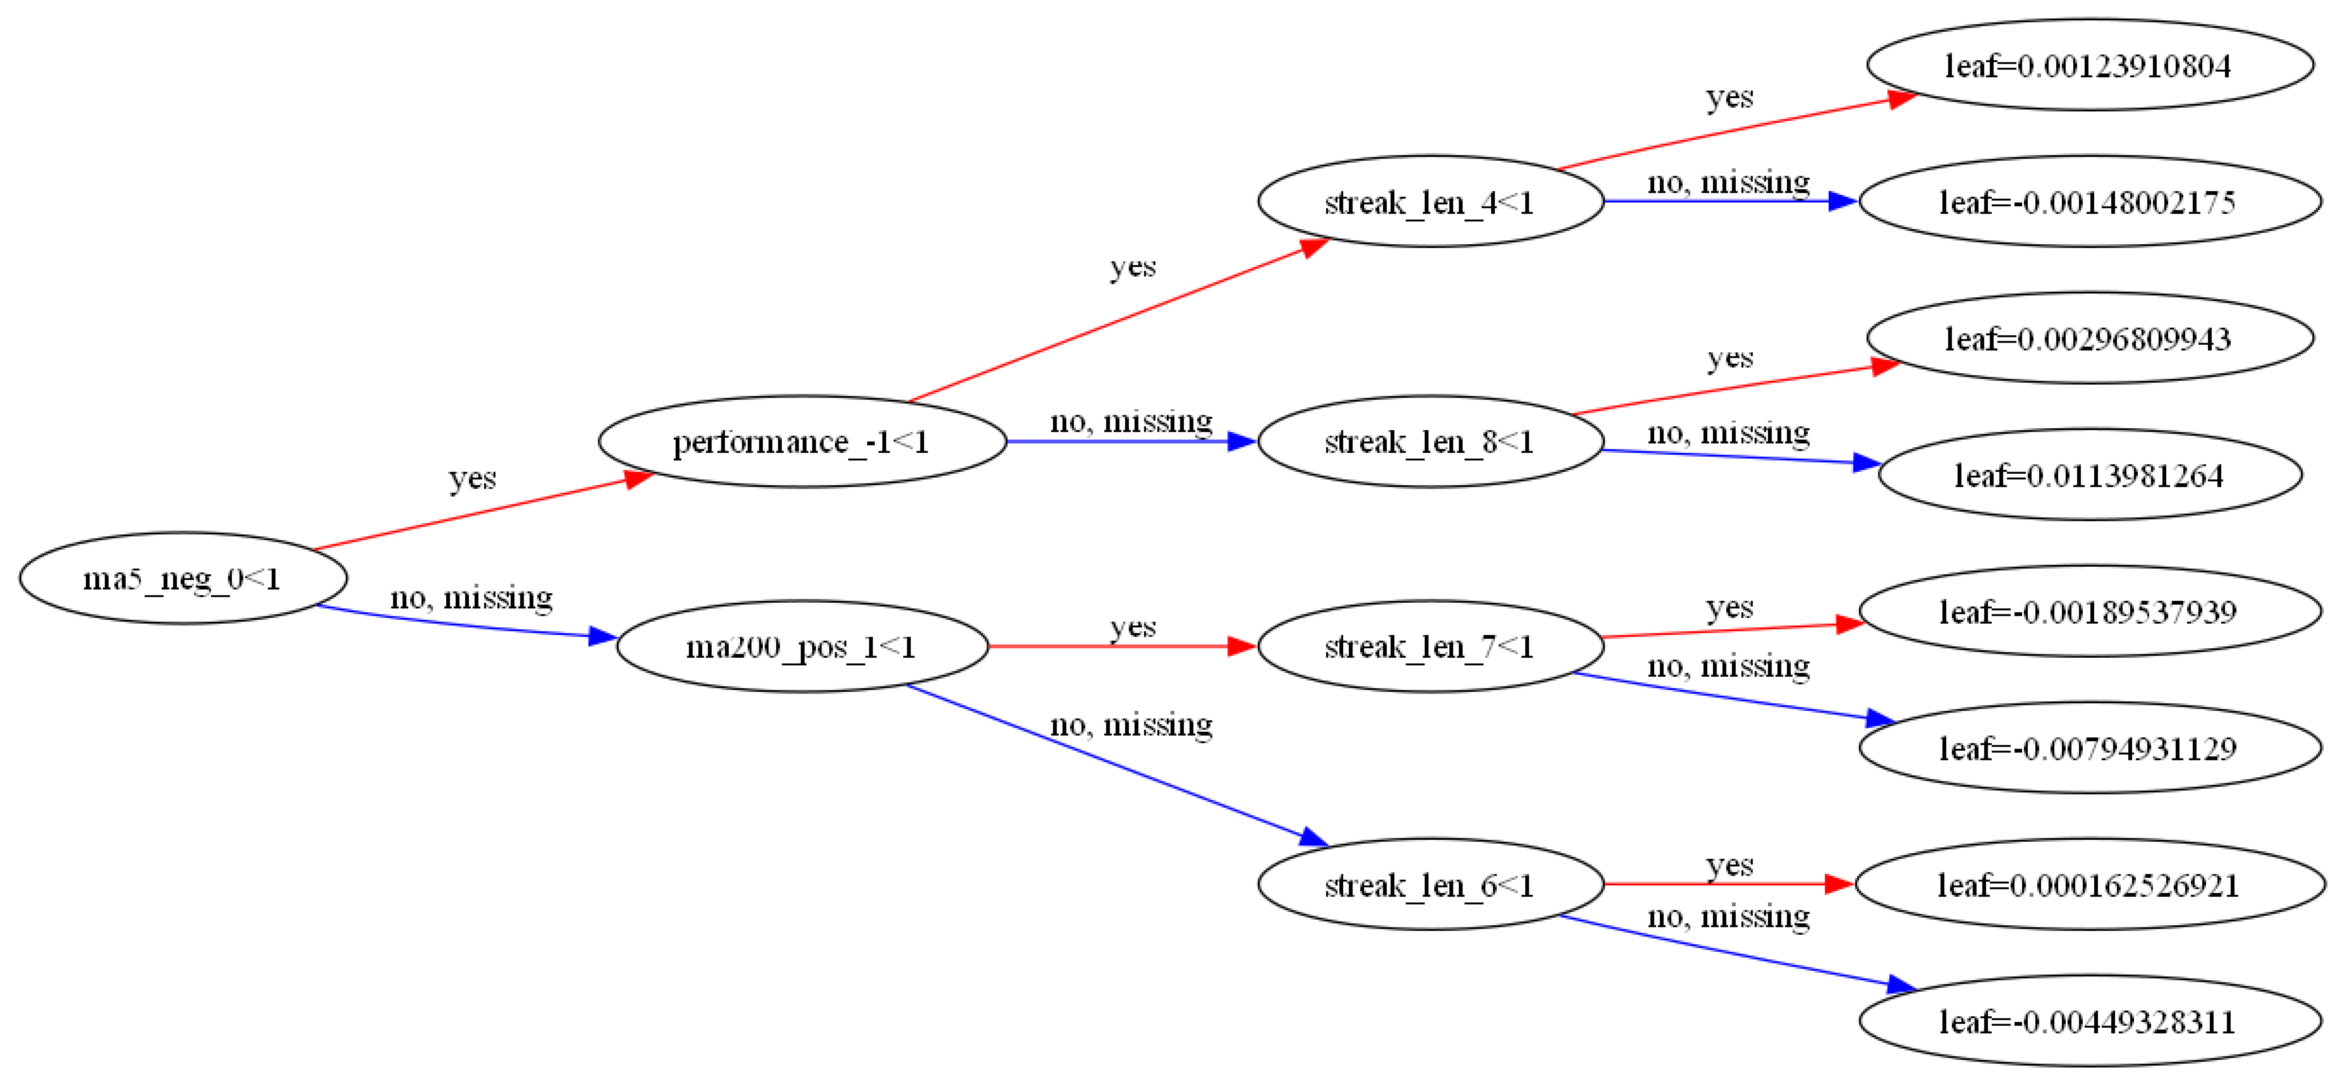

In [26]:
plot_tree(model, rankdir='LR')

<Axes: >

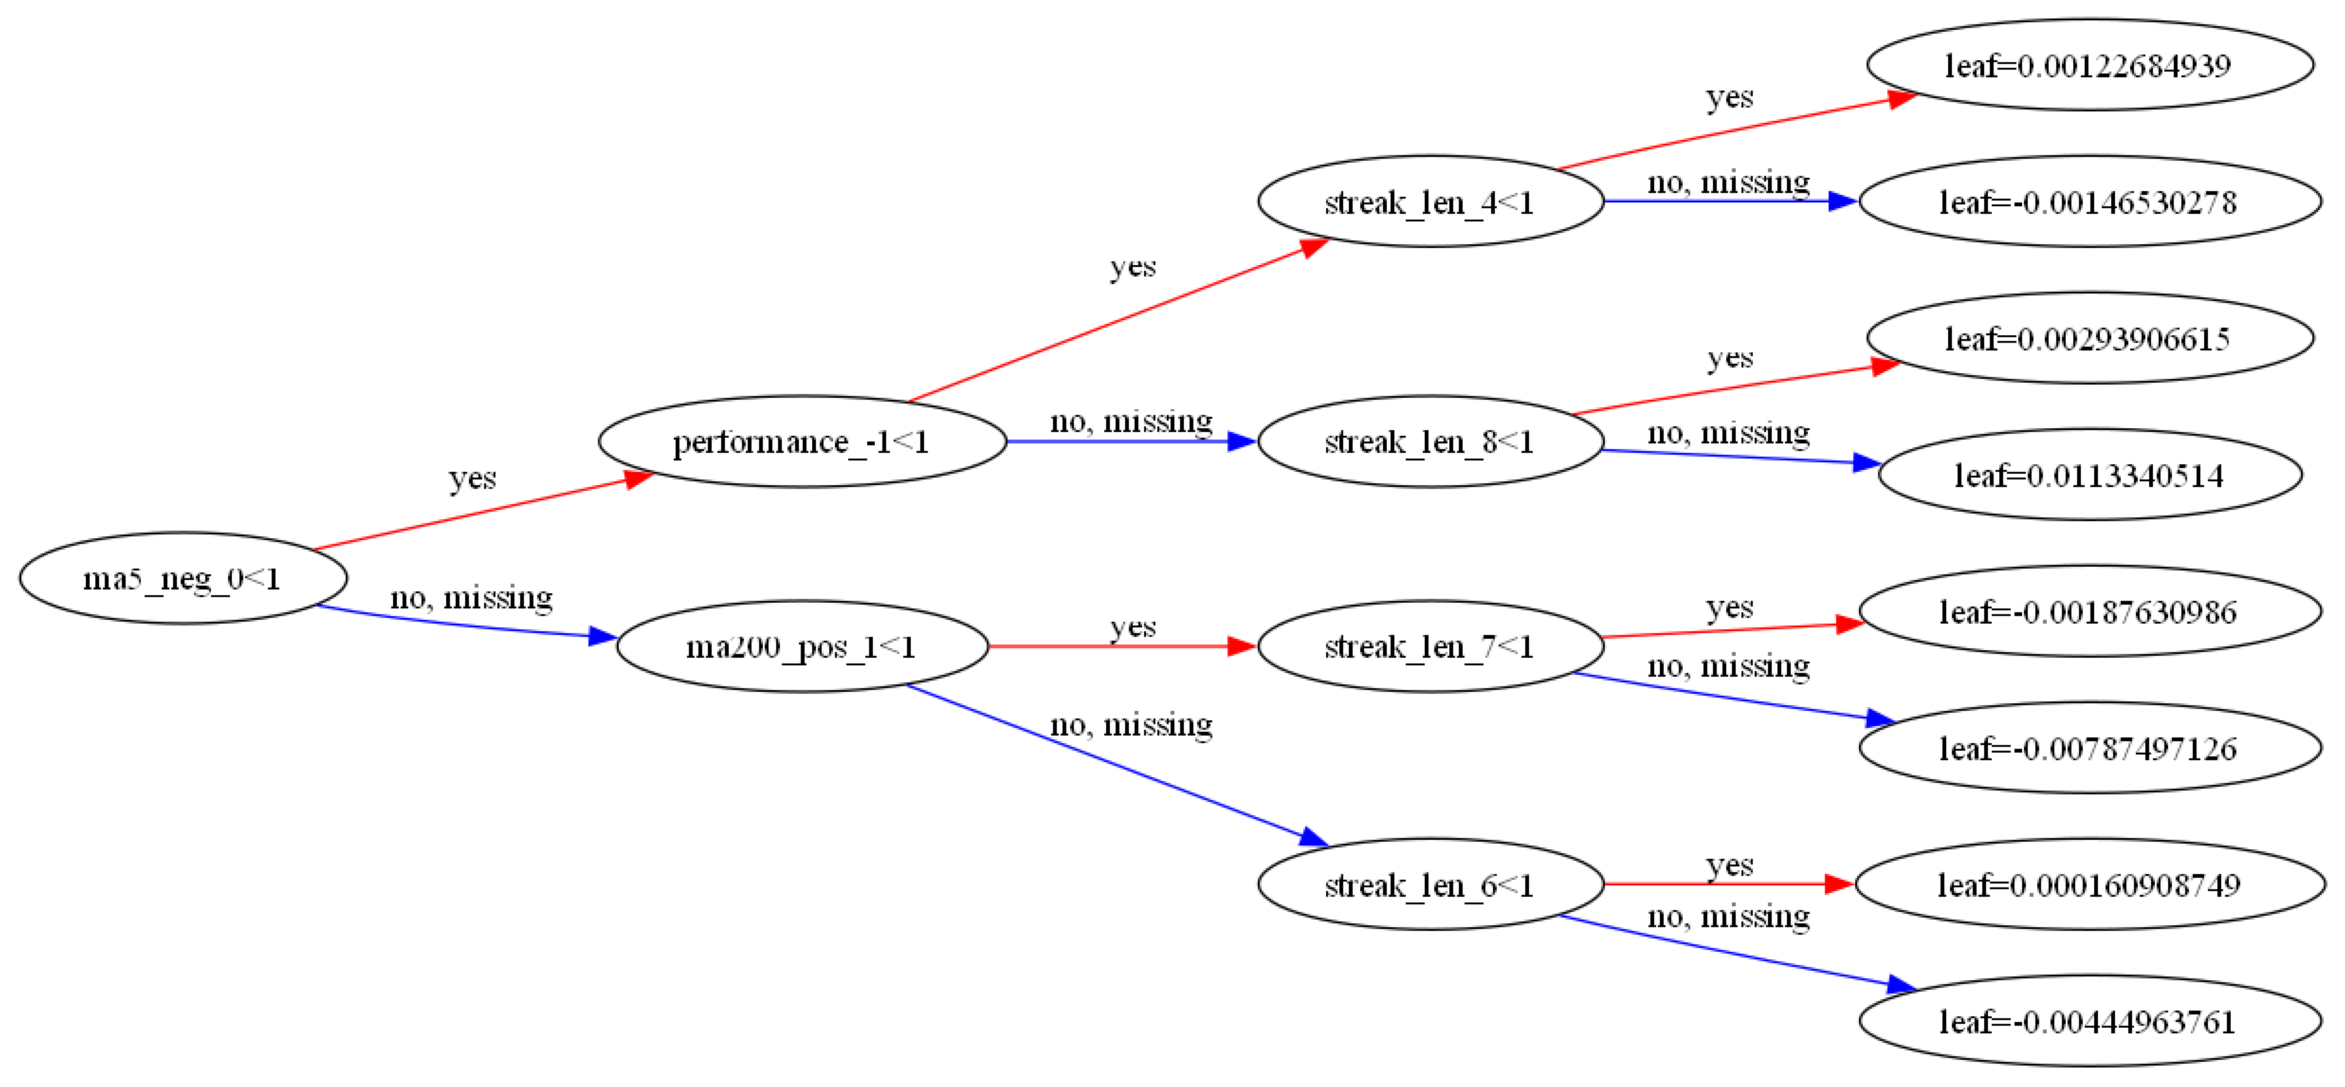

In [27]:
plot_tree(model, rankdir='LR', num_trees=1)

### 11. K-Fold Cross Validation

**K-Fold Cross-Validation:**
K-Fold Cross-Validation is a technique to evaluate a model's performance by splitting the dataset into `K` subsets (folds). The process involves:
1. Splitting the data into `K` equal parts.
2. Training the model on `K-1` folds and validating it on the remaining fold.
3. Repeating this process `K` times, each time using a different fold as the validation set.
4. Averaging the results to get the final performance metric.

**Key Metrics from K-Fold Cross-Validation**
- **Training Accuracy**: Average accuracy across all training folds.
- **Validation Accuracy**: Average accuracy across all validation folds.
- **Standard Deviation**: Measures the consistency of the model's performance across folds.

**Why Use K-Fold Cross-Validation?**
- Reduces overfitting by using the entire dataset for both training and validation.
- Provides a more reliable estimate of the model's performance compared to a single train-test split.

In [28]:
# Function to train and evaluate the model
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', **params)
    model.fit(X_train, train_targets)
    train_accuracy = accuracy_score(train_targets, model.predict(X_train))
    val_accuracy = accuracy_score(val_targets, model.predict(X_val))
    return model, train_accuracy, val_accuracy

# Initialize K-Fold cross-validation
kfold = KFold(n_splits=5)
fold_accuracies = []
models = []  # List to store trained models

# Perform K-Fold cross-validation
for train_idxs, val_idxs in kfold.split(x_train):
    X_train_fold, train_targets = x_train.iloc[train_idxs], y_train.iloc[train_idxs]
    X_val_fold, val_targets = x_train.iloc[val_idxs], y_train.iloc[val_idxs]
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train_fold, train_targets, X_val_fold, val_targets, max_depth=4, n_estimators=20)
    models.append(model)  # Store the trained model
    fold_accuracies.append(val_accuracy)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

# Calculate average validation accuracy and standard deviation
print("\nAverage Validation Accuracy:", np.mean(fold_accuracies))
print("Standard Deviation:", np.std(fold_accuracies))

# Function to average predictions from K-Fold models
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

# Generate average predictions
avg_preds = predict_avg(models, x_train)
print("\nAverage Predictions from K-Fold Models:\n", avg_preds)

Train Accuracy: 0.5739520958083832, Validation Accuracy: 0.527511961722488
Train Accuracy: 0.5776713558814726, Validation Accuracy: 0.511377245508982
Train Accuracy: 0.5815624064651302, Validation Accuracy: 0.5293413173652695
Train Accuracy: 0.5821610296318468, Validation Accuracy: 0.49700598802395207
Train Accuracy: 0.5764741095480395, Validation Accuracy: 0.5209580838323353

Average Validation Accuracy: 0.5172389192906053
Standard Deviation: 0.011912735638942415

Average Predictions from K-Fold Models:
 [1.  1.  0.8 ... 0.4 0.8 0. ]
